In [1]:
import numpy as np
from io import StringIO
import time,os, importlib
from tqdm import tqdm
np.set_printoptions(linewidth=160)
import lib.ktn_io as kio
import lib.gt_tools as gt

from lib.sampler import sampler as KTNsampler
from lib.aib_system import aib_system
from lib.discon_graph import rate_network

from scipy.sparse import save_npz,load_npz, diags, eye, csr_matrix,bmat,find
from scipy.sparse.linalg import eigs,inv,spsolve
from scipy.sparse.csgraph import connected_components
import scipy as sp
import scipy.linalg as spla
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm

Using tqdm package for pretty progress bars!


# Load Data

In [14]:
#data_dir = "KTN_data/LJ38/10k/"#4k_proc/"

data_dir = "KTN_data/LJ38/10k/"#4k_proc/"

#N,E,DU = kio.load_mat(data_dir,discon=True)

#print(DU.shape)

gt_check = False
generate = True
printout = True

beta = 10.0 # overwritten if generate = False
Emax = None


sys = aib_system(path=data_dir,beta=beta,generate=generate,Emax=Emax)
selA,selB = kio.load_AB(data_dir,np.ones(sys.N,bool))
sys.setup()
sys.define_AB_regions(selA,selB)

save_npz("LJ38_10k_K_10.npz",sys.K)


"""
selA = np.zeros(sys.N,bool)
selB = np.zeros(sys.N,bool)

Bi = sys.f.argmin()
Bc = DU.tocsc()[:,Bi].indices
selB[Bi]=True
selB[Bc[sys.f[Bc].argmin()]]=True

Ai = sys.f.argmax()
Ac = DU.tocsc()[:,Ai].indices
selA[Ai]=True
selA[Ac[sys.f[Ac].argmax()]]=True

#Bind = [sys.f.argmin()]
#Aind = [sys.f.argmax()]
sys.define_AB_regions(selA,selB)
"""
Aind = np.arange(sys.N)[selA]
Bind = np.arange(sys.N)[selB]
np.savetxt("Aind.txt",Aind,fmt="%d")
np.savetxt("Bind.txt",Bind,fmt="%d")

print(sys.K.shape)

print(Aind[sys.f[sys.selA].argmin()],Bind[sys.f[sys.selB].argmin()])

N,N_TS: 9999 10096
NA, NB, NI: 5 395 4910
(5310, 5310)
0 15


In [6]:
print(Aind,Bind)

[0 1 2 3 4] [  5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238
 239 240 241 242 243 244 245 246 247 248 249 2

# Find Path

In [40]:
depth=4
limit=100

Aind = np.arange(sys.N)[selA]
Bind = np.arange(sys.N)[selB]

print(len(path))


path, path_region = sys.find_path(Bind[sys.f[sys.selB].argmin()],Aind[sys.f[sys.selA].argmin()],depth=depth,limit=limit,strategy="RATE")
print(path_region.sum())

7

path: 0 -> 1 -> 61 -> 389 -> 474 -> 1353 -> 1488

268


# Graph transform away other states (optional)

In [25]:
# remove all but one A, B state
rm_reg = ~path_region
rm_reg[selA] = True
rm_reg[selB] = True
rm_reg[Aind[sys.f[selA].argmin()]] = False
rm_reg[Bind[sys.f[selB].argmin()]] = False

sys.gt(rm_reg)
selA = selA[~rm_reg]
selB = selB[~rm_reg]
print(selA.sum(),selB.sum())

sys.setup()
sys.define_AB_regions(selA,selB)

Aind = np.arange(sys.N)[selA]
Bind = np.arange(sys.N)[selB]

path, path_region = sys.find_path(Aind[sys.f[sys.selA].argmin()],Bind[sys.f[sys.selB].argmin()],depth=depth,limit=limit,strategy="RATE")
print(path_region.sum())
bpath, bpath_region = sys.find_path(Aind[sys.f[sys.selA].argmin()],Bind[sys.f[sys.selB].argmin()],depth=1,limit=80,strategy="RATE")
print(bpath_region.sum())


1 1
NA, NB, NI: 1 1 432

path: 0 -> 28 -> 96 -> 177 -> 1

128

path: 0 -> 28 -> 96 -> 177 -> 1

105


# Disconnectivity Graph (Optional)

In [41]:
import pickle
f_file = open('output/LJ13/Energies.dat','w')
r_file = open('output/LJ13/Rates.dat','w')

DU = DU.tocsc()

pbar = tqdm(total=N,leave=False,mininterval=0)
for i in np.arange(N):
    f_file.write("%d %f\n" % (i,E[i]))
    _du = DU[:,i].data
    for _i,f in enumerate(DU[:,i].indices):
        r_file.write("%d %d 0.0 %f\n" % (i,f,_du[_i]))
    pbar.update(1)
f_file.close()
r_file.close()










  0%|          | 0/1510 [00:00<?, ?it/s]





  0%|          | 1/1510 [00:00<00:03, 390.06it/s]





  0%|          | 2/1510 [00:00<00:04, 369.22it/s]





  0%|          | 3/1510 [00:00<00:04, 376.51it/s]





  0%|          | 4/1510 [00:00<00:04, 351.26it/s]





  0%|          | 5/1510 [00:00<00:03, 386.82it/s]





  0%|          | 6/1510 [00:00<00:03, 436.67it/s]





  0%|          | 7/1510 [00:00<00:04, 350.20it/s]





  1%|          | 8/1510 [00:00<00:04, 324.05it/s]





  1%|          | 9/1510 [00:00<00:04, 323.06it/s]





  1%|          | 10/1510 [00:00<00:05, 282.64it/s]





  1%|          | 11/1510 [00:00<00:05, 299.24it/s]





  1%|          | 12/1510 [00:00<00:04, 323.53it/s]





  1%|          | 13/1510 [00:00<00:04, 347.45it/s]





  1%|          | 14/1510 [00:00<00:04, 369.55it/s]





  1%|          | 15/1510 [00:00<00:03, 377.25it/s]





  1%|          | 16/1510 [00:00<00:03, 375.73it/s]





  1%|          | 17/1510 [00:00<00:04, 346.14it/s]





  1%|

 15%|█▍        | 219/1510 [00:00<00:02, 437.74it/s]





 15%|█▍        | 220/1510 [00:00<00:07, 175.68it/s]





 15%|█▍        | 221/1510 [00:00<00:06, 210.01it/s]





 15%|█▍        | 222/1510 [00:00<00:05, 247.47it/s]





 15%|█▍        | 223/1510 [00:00<00:05, 252.35it/s]





 15%|█▍        | 224/1510 [00:00<00:04, 275.70it/s]





 15%|█▍        | 225/1510 [00:00<00:04, 265.28it/s]





 15%|█▍        | 226/1510 [00:00<00:04, 287.36it/s]





 15%|█▌        | 227/1510 [00:00<00:05, 215.20it/s]





 15%|█▌        | 228/1510 [00:00<00:05, 229.68it/s]





 15%|█▌        | 229/1510 [00:00<00:04, 257.14it/s]





 15%|█▌        | 230/1510 [00:00<00:04, 275.58it/s]





 15%|█▌        | 231/1510 [00:00<00:04, 296.21it/s]





 15%|█▌        | 232/1510 [00:00<00:04, 273.31it/s]





 15%|█▌        | 233/1510 [00:00<00:04, 278.99it/s]





 15%|█▌        | 234/1510 [00:00<00:04, 303.59it/s]





 16%|█▌        | 235/1510 [00:00<00:04, 282.02it/s]





 16%|█▌        | 236/1510 [00:0

 29%|██▉       | 437/1510 [00:01<00:04, 224.60it/s]





 29%|██▉       | 438/1510 [00:01<00:04, 252.87it/s]





 29%|██▉       | 439/1510 [00:01<00:03, 301.22it/s]





 29%|██▉       | 440/1510 [00:01<00:03, 352.12it/s]





 29%|██▉       | 441/1510 [00:01<00:02, 395.37it/s]





 29%|██▉       | 442/1510 [00:01<00:02, 437.79it/s]





 29%|██▉       | 443/1510 [00:01<00:02, 474.21it/s]





 29%|██▉       | 444/1510 [00:01<00:02, 381.57it/s]





 29%|██▉       | 445/1510 [00:01<00:03, 270.36it/s]





 30%|██▉       | 446/1510 [00:01<00:03, 304.18it/s]





 30%|██▉       | 447/1510 [00:01<00:03, 344.61it/s]





 30%|██▉       | 448/1510 [00:01<00:02, 382.97it/s]





 30%|██▉       | 449/1510 [00:01<00:03, 321.73it/s]





 30%|██▉       | 450/1510 [00:01<00:02, 368.75it/s]





 30%|██▉       | 451/1510 [00:01<00:02, 407.71it/s]





 30%|██▉       | 452/1510 [00:01<00:02, 442.85it/s]





 30%|███       | 453/1510 [00:01<00:03, 344.39it/s]





 30%|███       | 454/1510 [00:0

 43%|████▎     | 655/1510 [00:02<00:03, 265.21it/s]





 43%|████▎     | 656/1510 [00:02<00:03, 242.37it/s]





 44%|████▎     | 657/1510 [00:02<00:03, 271.86it/s]





 44%|████▎     | 658/1510 [00:02<00:02, 299.49it/s]





 44%|████▎     | 659/1510 [00:02<00:02, 317.91it/s]





 44%|████▎     | 660/1510 [00:02<00:03, 226.46it/s]





 44%|████▍     | 661/1510 [00:02<00:03, 262.34it/s]





 44%|████▍     | 662/1510 [00:02<00:02, 293.37it/s]





 44%|████▍     | 663/1510 [00:02<00:03, 261.36it/s]





 44%|████▍     | 664/1510 [00:02<00:03, 268.95it/s]





 44%|████▍     | 665/1510 [00:02<00:03, 274.81it/s]





 44%|████▍     | 666/1510 [00:02<00:02, 286.37it/s]





 44%|████▍     | 667/1510 [00:02<00:02, 313.38it/s]





 44%|████▍     | 668/1510 [00:02<00:03, 267.49it/s]





 44%|████▍     | 669/1510 [00:02<00:02, 292.20it/s]





 44%|████▍     | 670/1510 [00:02<00:02, 301.27it/s]





 44%|████▍     | 671/1510 [00:02<00:03, 279.59it/s]





 45%|████▍     | 672/1510 [00:0

 58%|█████▊    | 873/1510 [00:02<00:02, 220.70it/s]





 58%|█████▊    | 874/1510 [00:02<00:02, 265.67it/s]





 58%|█████▊    | 875/1510 [00:02<00:02, 313.37it/s]





 58%|█████▊    | 876/1510 [00:02<00:01, 363.29it/s]





 58%|█████▊    | 877/1510 [00:02<00:01, 404.27it/s]





 58%|█████▊    | 878/1510 [00:02<00:01, 379.62it/s]





 58%|█████▊    | 879/1510 [00:02<00:01, 361.11it/s]





 58%|█████▊    | 880/1510 [00:02<00:01, 368.97it/s]





 58%|█████▊    | 881/1510 [00:02<00:01, 379.17it/s]





 58%|█████▊    | 882/1510 [00:02<00:01, 385.74it/s]





 58%|█████▊    | 883/1510 [00:02<00:01, 391.13it/s]





 59%|█████▊    | 884/1510 [00:02<00:01, 328.06it/s]





 59%|█████▊    | 885/1510 [00:02<00:01, 326.68it/s]





 59%|█████▊    | 886/1510 [00:02<00:01, 354.02it/s]





 59%|█████▊    | 887/1510 [00:02<00:01, 379.16it/s]





 59%|█████▉    | 888/1510 [00:02<00:02, 285.31it/s]





 59%|█████▉    | 889/1510 [00:02<00:01, 318.67it/s]





 59%|█████▉    | 890/1510 [00:0

 72%|███████▏  | 1090/1510 [00:03<00:01, 302.48it/s]





 72%|███████▏  | 1091/1510 [00:03<00:01, 253.78it/s]





 72%|███████▏  | 1092/1510 [00:03<00:01, 264.67it/s]





 72%|███████▏  | 1093/1510 [00:03<00:01, 287.15it/s]





 72%|███████▏  | 1094/1510 [00:03<00:01, 235.30it/s]





 73%|███████▎  | 1095/1510 [00:03<00:01, 269.84it/s]





 73%|███████▎  | 1096/1510 [00:03<00:01, 304.57it/s]





 73%|███████▎  | 1097/1510 [00:03<00:01, 332.42it/s]





 73%|███████▎  | 1098/1510 [00:03<00:01, 367.35it/s]





 73%|███████▎  | 1099/1510 [00:03<00:01, 366.43it/s]





 73%|███████▎  | 1100/1510 [00:03<00:01, 347.13it/s]





 73%|███████▎  | 1101/1510 [00:03<00:01, 311.39it/s]





 73%|███████▎  | 1102/1510 [00:03<00:01, 331.46it/s]





 73%|███████▎  | 1103/1510 [00:03<00:01, 277.51it/s]





 73%|███████▎  | 1104/1510 [00:03<00:01, 307.97it/s]





 73%|███████▎  | 1105/1510 [00:03<00:01, 333.39it/s]





 73%|███████▎  | 1106/1510 [00:03<00:01, 345.23it/s]





 73%|███████▎ 

 86%|████████▋ | 1304/1510 [00:04<00:00, 276.17it/s]





 86%|████████▋ | 1305/1510 [00:04<00:00, 298.63it/s]





 86%|████████▋ | 1306/1510 [00:04<00:00, 312.94it/s]





 87%|████████▋ | 1307/1510 [00:04<00:00, 326.78it/s]





 87%|████████▋ | 1308/1510 [00:04<00:00, 333.24it/s]





 87%|████████▋ | 1309/1510 [00:04<00:00, 305.92it/s]





 87%|████████▋ | 1310/1510 [00:04<00:00, 311.58it/s]





 87%|████████▋ | 1311/1510 [00:04<00:00, 315.00it/s]





 87%|████████▋ | 1312/1510 [00:04<00:00, 336.28it/s]





 87%|████████▋ | 1313/1510 [00:04<00:00, 309.38it/s]





 87%|████████▋ | 1314/1510 [00:04<00:00, 331.02it/s]





 87%|████████▋ | 1315/1510 [00:04<00:00, 359.15it/s]





 87%|████████▋ | 1316/1510 [00:04<00:00, 388.17it/s]





 87%|████████▋ | 1317/1510 [00:04<00:00, 412.79it/s]





 87%|████████▋ | 1318/1510 [00:04<00:00, 434.24it/s]





 87%|████████▋ | 1319/1510 [00:04<00:00, 451.62it/s]





 87%|████████▋ | 1320/1510 [00:04<00:00, 449.53it/s]





 87%|████████▋

In [10]:
#rn = rate_network(file="output/Rates.dat",efile="output/Energies.dat")

#rn.build_tree()

#rn.plot(w=8,h=6,dump=False)


900









  0%|          | 0/268 [00:00<?, ?it/s]






  1%|          | 3/268 [00:00<00:09, 27.22it/s]






  3%|▎         | 8/268 [00:00<00:08, 31.17it/s]






  5%|▌         | 14/268 [00:00<00:07, 35.99it/s]






 10%|█         | 27/268 [00:00<00:05, 45.87it/s]






 15%|█▍        | 40/268 [00:00<00:04, 56.87it/s]






 18%|█▊        | 47/268 [00:00<00:03, 59.30it/s]






 22%|██▏       | 59/268 [00:00<00:02, 69.74it/s]






 27%|██▋       | 73/268 [00:00<00:02, 81.94it/s]






 32%|███▏      | 87/268 [00:00<00:01, 92.76it/s]






 36%|███▌      | 96/268 [00:01<00:01, 91.45it/s]






 41%|████      | 109/268 [00:01<00:01, 98.95it/s]






 44%|████▍     | 119/268 [00:01<00:01, 95.81it/s]






 48%|████▊     | 129/268 [00:01<00:01, 95.78it/s]






 51%|█████     | 136/268 [00:01<00:01, 86.03it/s]






 55%|█████▍    | 147/268 [00:01<00:01, 91.87it/s]






 59%|█████▉    | 158/268 [00:01<00:01, 95.77it/s]






 64%|██████▍   | 171/268 [00:01<00:00, 102.58it/s]






 68%|█

INITIAL SAMPLE DONE : found 10003/20604 pairs; 10601 remaining
DIRECT =  0 + 1.024e-23 = 1.024e-23
GT = 1.024e-23 +  0 = 1.024e-23


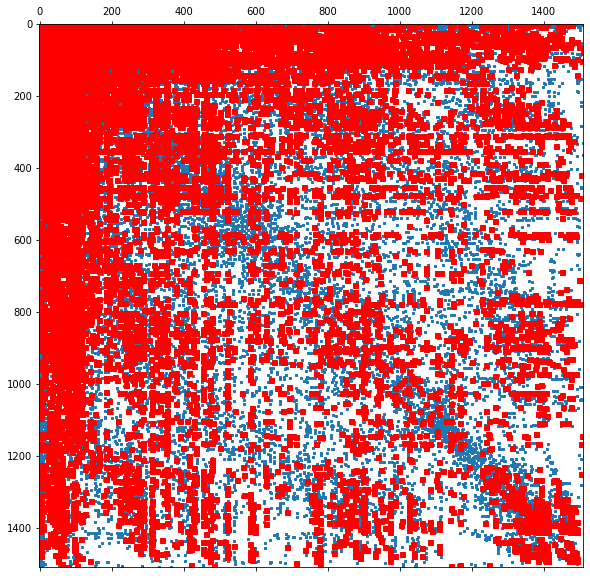

In [42]:
""" Initialize sampler """
sampler = KTNsampler(sys)

sampler.initial_sample_path_region(np.arange(sys.N)[path_region],ncs=100)
#sampler.initial_sample_path_region(np.arange(sys.N)[bpath_region],ncs=10)

bab,gterr = sampler.new_true_branching_probability()

plt.figure(figsize=(10,10))

plt.spy(sampler.sys.K,markersize=2.0)
plt.spy(sampler.sys.rK,markersize=5.0,c='r')
plt.show()

In [43]:
bab,gterr = sampler.new_true_branching_probability()

keylist = ['TotalMaxMin','TotalSparseMaxMin','ExpectMaxMin','ExpectMaxMaxMin','SingleMaxMin']

if printout:
    """ open output file """
    name = data_dir.split("/")[-1-int(data_dir[-1]=="/")]
    ff = open('output/pab_converge_GT_2_%s' % name,'w')
    header = "#iteration\tnrp\tebab\t"
    for key in keylist:
        header += key+"\t"
    header += "Sparsity\tbab\n"
    ff.write(header)

nscycles = 30
ncycles = 100
npairs = 2
ss = 0 # >0 if we do single ended search


for jj in range(nscycles):
    npc=0
    pbar=tqdm(total=ncycles,miniters=0,leave=True)
    ss=False
    ssc=0
    irp = sampler.remaining_pairs()
    pp,gres,npc = sampler.sample(npairs=npairs + 10*int(ss),ss=ss) # sampling process. Returns
    for ii in range(ncycles):

        orp = sampler.remaining_pairs() # DIVINE INFORMATION- number of remaining pairs

        # sampling process returns pp = number of pairs, sens = vector of various net sensitivities and found sparsity, ebab = predicted branching probability (to be compared to bab)
        nnz = sampler.sys.rK.nnz
        pp,res,_npc = sampler.sample(npairs=npairs + 10*int(ss),ss=ss) # sampling process. Returns

        npc += _npc
        if _npc!=(sampler.sys.rK.nnz-nnz)//2:
            print("npc",_npc,sampler.sys.rK.nnz-nnz)
        nrp = sampler.remaining_pairs() # DIVINE INFORMATION- number of remaining pairs
        ss = orp==nrp
        ssc += int(ss)
        probe_compl = float(sampler.probed.sum()) / float(sampler.sys.K.shape[0]*sampler.sys.K.shape[1])

        if printout:
            ff.write("%d %d %10.10g %10.10g " % (ii,nrp,probe_compl,res['ebab']))
            for key in keylist:
                ff.write("%10.10g %10.10g " % (res[key][0],res[key][1]))
            ff.write("%10.10g %10.10g\n" % (res['Sparsity'],bab))

        pbar.update(1)
        for key in ['TotalSparseMaxMin','SingleMaxMin','ExpectMaxMaxMin']:
            gres[key][0] = min(gres[key][0],res[key][0])
            gres[key][1] = max(gres[key][1],res[key][1])
    pbar.close()
    ebab = res['ebab']
    
    print("\n{: <4} {: <5} ".format("%d" % ii,"%1.4g" % (ebab/bab)),end="| ")
    for key in ['TotalSparseMaxMin','SingleMaxMin','ExpectMaxMaxMin']:
        
        tmm = [ (1.0-(1.0-ebab)*np.exp(-gres[key][0]/(1.0-ebab)))/bab,(np.exp(gres[key][1]/ebab)-1.0)*ebab/bab]
        
        print("{: <5} {: <5} {: <5}".format("%1.4g" % tmm[0],"%1.4g" % tmm[1],"%1.4g" % (tmm[0]+tmm[1])),end="| ")
    print("{: <5} {: <5} | {: <5} {: <5} {: <5} | {: <5} {: <5}".format(\
    "%1.4g" % res['Sparsity'],\
    "%1.4g" % probe_compl,\
    "%1.4g" % res['MaxInRegion'][0],"%1.4g" % res['MaxInRegion'][1],"%1.4g" % res['MaxInRegion'][2],\
    "%d" % (irp-nrp),"%d" % (npc)),"\n")

if printout:
    ff.close()



DIRECT =  0 + 1.024e-23 = 1.024e-23









  0%|          | 0/100 [00:00<?, ?it/s]

GT = 1.024e-23 +  0 = 1.024e-23









  1%|          | 1/100 [00:01<02:00,  1.21s/it]






  2%|▏         | 2/100 [00:01<01:39,  1.01s/it]






  3%|▎         | 3/100 [00:02<01:22,  1.17it/s]






  4%|▍         | 4/100 [00:02<01:13,  1.31it/s]






  5%|▌         | 5/100 [00:03<01:11,  1.33it/s]






  6%|▌         | 6/100 [00:04<01:09,  1.36it/s]






  7%|▋         | 7/100 [00:04<01:05,  1.42it/s]






  8%|▊         | 8/100 [00:05<00:59,  1.54it/s]






  9%|▉         | 9/100 [00:05<00:55,  1.65it/s]






 10%|█         | 10/100 [00:06<00:53,  1.68it/s]






 11%|█         | 11/100 [00:07<00:53,  1.67it/s]






 12%|█▏        | 12/100 [00:07<00:52,  1.69it/s]






 13%|█▎        | 13/100 [00:08<00:49,  1.76it/s]






 14%|█▍        | 14/100 [00:08<00:50,  1.70it/s]






 15%|█▌        | 15/100 [00:09<00:47,  1.79it/s]

KeyboardInterrupt: 

# Plot

0.0001220703125


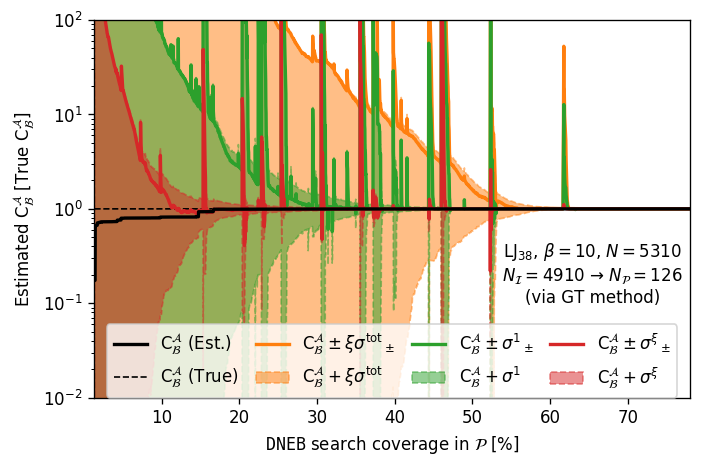

In [31]:
name = data_dir.split("/")[-1-int(data_dir[-1]=="/")]

savefig = True
name='10k'
data = np.loadtxt('output/pab_converge_GT_2_%s' % name)


filename = 'output/%s/dneb_ip_gs_GT_2.pdf' % (name)


#NI = sampler.sys.N-sampler.sys.NA-sampler.sys.NB

#title = r"LJ$_{38}$ cluster, $N_\mathcal{I}:4910\to126$ states, $\beta=$%d, Initial Path: Simulated $\tt{DNEB}$" % (beta)


fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=120)

#ax.set_title(title,fontsize=10)
ax.set_xlabel(r"$\tt{DNEB}$ search coverage in $\mathcal{P}$ [%]")


ax.set_ylabel(r"Estimated ${\rm C}^\mathcal{A}_\mathcal{B}$ [True ${\rm C}^\mathcal{A}_\mathcal{B}$]")


"""
0-3: iteration nrp probe_compl ebab
4-7: TotalMaxMin +/- TotalSparseMaxMin +/-
8-11: ExpectMaxMin +/- ExpectMaxMaxMin +/-
12-13: SingleMaxMin +/-
14: Sparsity
15: bab
"""

obs = [6,12,8]

"""
Labels
"""

labs = [r"$\xi\sigma^{\rm tot}$",r"${\sigma}^{1}$",r"${\sigma}^{\xi}$"]

labels = [r"${\rm C}^\mathcal{A}_\mathcal{B}$ (Est.)",r"${\rm C}^\mathcal{A}_\mathcal{B}$ (True)"]
for lab in labs:
    labels.append(r"${\rm C}^\mathcal{A}_\mathcal{B}\pm$%s$_\pm$" % lab)
    labels.append(r"${\rm C}^\mathcal{A}_\mathcal{B}+$%s" % lab)


"""
exp bounds
"""
for iii in obs:
    data[:,iii] = (1.0-data[:,3].copy())*(1.-np.exp(-data[:,iii]/(1.0-data[:,3].copy())))
    data[:,iii+1] = data[:,3].copy()*(np.exp(data[:,iii+1]/data[:,3].copy())-1.0)

"""
normalize
"""
bab = data[:,-1][-1].copy()
for iii in obs:
    data[:,iii] /= data[:,-1]
    data[:,iii+1] /= data[:,-1]
data[:,3] /= data[:,-1]
data[:,-1] /= data[:,-1]

#ncab = sys.K[sys.selA+sys.selB,:][:,sys.selA+sys.selB].nnz
ncab = 2.0/128**2
print(ncab)

xa = (data[:,2]-(ncab / float(sampler.sys.N**2))) * 100.0 - 10.

t = ax.plot(xa,data[:,-1],'k--',lw=1)[0]

s,sb = [], []
for ci,iii in enumerate(obs):
    sb.append(ax.fill_between(xa,data[:,3]+data[:,iii],data[:,3]+data[:,iii+1],alpha=0.5,color='C'+str(ci+1),lw=1,ls='--'))
for ci,iii in enumerate(obs):
    s.append(ax.plot(xa,data[:,3]+data[:,iii]+data[:,iii+1],'C%s-' % str(ci+1),lw=2)[0])

handles = [ax.plot(xa,data[:,3],'k-',lw=2)[0],t]
for ssi in range(len(sb)):
    handles.append(s[ssi])
    handles.append(sb[ssi])


ax.set_yscale('log')
ax.set_ylim(0.01,100.0)#bab,1.0/bab)
ax.set_xlim(xa.min(),78.0)#xa.max())

ax.legend(handles,labels,loc='lower center',ncol=4, columnspacing=1.0, borderaxespad=0.,fontsize=10)#,title=title) # mode="expand",

ax.text(65.5,0.1,r"LJ$_{38}$, $\beta=$%d, $N=5310$"
        "\n"
        r"$N_\mathcal{I}=4910$ $\to$ $N_\mathcal{P}=126$"
        "\n(via GT method)"% (beta),ha="center")
        #r"$N_\mathcal{A}+N_\mathcal{B}=400\to2$"
        #"\n"
        #r"$N_\mathcal{I}=4910\to126$" % (beta),ha="center")


plt.tight_layout()

#fig.subplots_adjust(hspace=0.4)

if savefig:
    plt.savefig(filename,dpi=400)

plt.show()


0.0009469135802469136


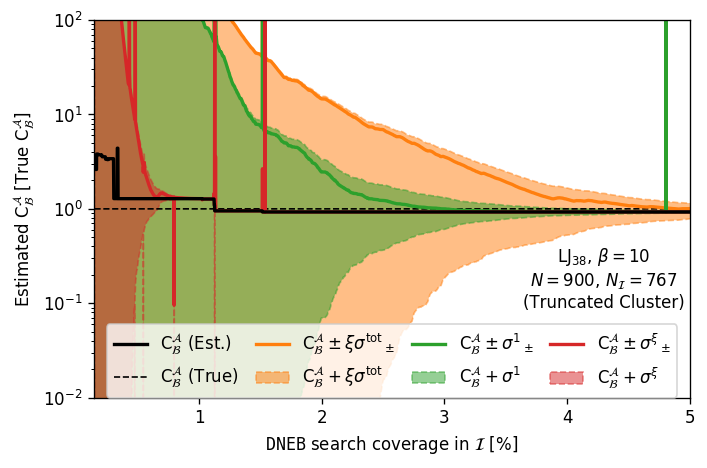

In [118]:
name = data_dir.split("/")[-1-int(data_dir[-1]=="/")]

savefig = True
name='4k_proc'
data = np.loadtxt('output/pab_converge_%s' % name)


filename = 'output/%s/dneb_ip_gs_2.pdf' % (name)


#NI = sampler.sys.N-sampler.sys.NA-sampler.sys.NB

#title = r"LJ$_{38}$ cluster, $N_\mathcal{I}:4910\to126$ states, $\beta=$%d, Initial Path: Simulated $\tt{DNEB}$" % (beta)


fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=120)

#ax.set_title(title,fontsize=10)
ax.set_xlabel(r"$\tt{DNEB}$ search coverage in $\mathcal{I}$ [%]")


ax.set_ylabel(r"Estimated ${\rm C}^\mathcal{A}_\mathcal{B}$ [True ${\rm C}^\mathcal{A}_\mathcal{B}$]")


"""
0-3: iteration nrp probe_compl ebab
4-7: TotalMaxMin +/- TotalSparseMaxMin +/-
8-11: ExpectMaxMin +/- ExpectMaxMaxMin +/-
12-13: SingleMaxMin +/-
14: Sparsity
15: bab
"""

obs = [6,12,8]

"""
Labels
"""

labs = [r"$\xi\sigma^{\rm tot}$",r"${\sigma}^{1}$",r"${\sigma}^{\xi}$"]

labels = [r"${\rm C}^\mathcal{A}_\mathcal{B}$ (Est.)",r"${\rm C}^\mathcal{A}_\mathcal{B}$ (True)"]
for lab in labs:
    labels.append(r"${\rm C}^\mathcal{A}_\mathcal{B}\pm$%s$_\pm$" % lab)
    labels.append(r"${\rm C}^\mathcal{A}_\mathcal{B}+$%s" % lab)


"""
exp bounds
"""
for iii in obs:
    data[:,iii] = (1.0-data[:,3].copy())*(1.-np.exp(-data[:,iii]/(1.0-data[:,3].copy())))
    data[:,iii+1] = data[:,3].copy()*(np.exp(data[:,iii+1]/data[:,3].copy())-1.0)

"""
normalize
"""
bab = data[:,-1][-1].copy()
for iii in obs:
    data[:,iii] /= data[:,-1]
    data[:,iii+1] /= data[:,-1]
data[:,3] /= data[:,-1]
data[:,-1] /= data[:,-1]

#ncab = sys.K[sys.selA+sys.selB,:][:,sys.selA+sys.selB].nnz
ncab = 767./900.0**2
print(ncab)

xa = (data[:,2]-ncab) * 100.0

t = ax.plot(xa,data[:,-1],'k--',lw=1)[0]

s,sb = [], []
for ci,iii in enumerate(obs):
    sb.append(ax.fill_between(xa,data[:,3]+data[:,iii],data[:,3]+data[:,iii+1],alpha=0.5,color='C'+str(ci+1),lw=1,ls='--'))
for ci,iii in enumerate(obs):
    s.append(ax.plot(xa,data[:,3]+data[:,iii]+data[:,iii+1],'C%s-' % str(ci+1),lw=2)[0])

handles = [ax.plot(xa,data[:,3],'k-',lw=2)[0],t]
for ssi in range(len(sb)):
    handles.append(s[ssi])
    handles.append(sb[ssi])


ax.set_yscale('log')
ax.set_ylim(0.01,100.0)#bab,1.0/bab)
ax.set_xlim(xa.min(),5.0)#xa.max())

ax.legend(handles,labels,loc='lower center',ncol=4, columnspacing=1.0, borderaxespad=0.,fontsize=10)#,title=title) # mode="expand",

ax.text(4.3,0.09,r"LJ$_{38}$, $\beta=$%d"#, $N=900$"
        "\n"
        r"$N=900$, $N_\mathcal{I}=767$"
        "\n(Truncated Cluster)" % (beta),ha="center")
        #r"$N_\mathcal{A}+N_\mathcal{B}=133$"
        #"\n"
        #r"$N_\mathcal{I}=767$" % (beta),ha="center")

plt.tight_layout()

#fig.subplots_adjust(hspace=0.4)

if savefig:
    plt.savefig(filename,dpi=400)

plt.show()
